# ECS7026P - Neural Networks and Deep Learning Coursework: CIFAR-10 Classification

**This code will first try to import torch. If it's not installed and the import fails, it will print a message indicating that PyTorch is not installed and then proceed to install it using pip.**

In [21]:
try:
    import torch
except ImportError:
    print("PyTorch is not installed. Installing now...")
    !pip install torch


In [22]:
!pip install seaborn
import seaborn as sns


In [23]:
# Import PyTorch library and its submodules
import torch
from torch import nn
import torch.nn.functional as F

# Import torchvision library and its submodules for datasets and transforms
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torchvision.transforms as transforms

# Import matplotlib for visualization purposes
import matplotlib.pyplot as plt
import seaborn as sns

# Import DataLoader for loading data efficiently
from torch.utils.data import DataLoader

# Import numpy for numerical operations
import numpy as np

# Import random for generating random numbers
import random

# Check versions of PyTorch and torchvision
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 2.1.2
torchvision version: 0.16.2


In [24]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Set random seed for CUDA if GPU is available
if device.type == "cuda":
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Uncomment the line below to display GPU information
# !nvidia-smi

Using device: cuda


In [25]:
BATCH_SIZE = 64
EPOCHS = 35
IMAGE_SIZE = 32

# Optimiser Constants
ADAMW_LEARNING_RATE = 0.001
ADAMW_WEIGHT_DECAY = 1e-2

# Block Constants
CONV2D_KERNEL_SIZE = 3
CONV2D_PADDING = 1
CONV2D_STRIDE = 1
MAXPOOL2D_KERNEL_SIZE = 2
MAXPOOL2D_STRIDE = 2

# Classifier Constants
DROPOUT_RATE = 0.5

# Task 1. Creating DataLoaders for CIFAR-10 Dataset (5%)

In [26]:
train_transformations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(IMAGE_SIZE, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
test_transformations = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [27]:
# Setup training data
train_data = datasets.CIFAR10(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=train_transformations, # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=test_transformations
)

Files already downloaded and verified
Files already downloaded and verified


Training sample

In [28]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[-0.6000, -0.3098, -0.0588,  ..., -1.0000, -1.0000, -1.0000],
          [-0.3490, -0.1373,  0.0118,  ..., -1.0000, -1.0000, -1.0000],
          [-0.1686, -0.0980, -0.0824,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [ 0.5216,  0.5529,  0.5765,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.4745,  0.5843,  0.7098,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.7882, -0.6000, -0.3569,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6078, -0.4353, -0.2784,  ..., -1.0000, -1.0000, -1.0000],
          [-0.5059, -0.4510, -0.4196,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [ 0.2000,  0.2392,  0.2863,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.1686,  0.3176,  0.4824,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.9373, -0.8353, -0.6627,  ..., -1.0000, -1.0000, -1.0000],
          [-0.8196, -0.6784,

In [29]:
# Checking the the shape of the image
image.shape

torch.Size([3, 32, 32])

In [30]:
# Checking the number of samples in train and test dataset
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [31]:
# Checking the different classes present in the dataset
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [32]:
# Displaying each class with its index
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [33]:
# Counting the records under each class
from collections import defaultdict

# Initialize a dictionary to store the count of records for each class
class_counts = defaultdict(int)

# Iterate over the training dataset to count the occurrences of each class label
for _, label in train_data:
    class_counts[class_names[label]] += 1

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")


Class: frog, Count: 5000
Class: truck, Count: 5000
Class: deer, Count: 5000
Class: automobile, Count: 5000
Class: bird, Count: 5000
Class: horse, Count: 5000
Class: ship, Count: 5000
Class: cat, Count: 5000
Class: dog, Count: 5000
Class: airplane, Count: 5000


**Inference: The above results show that we have balanced classes**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 32, 32])


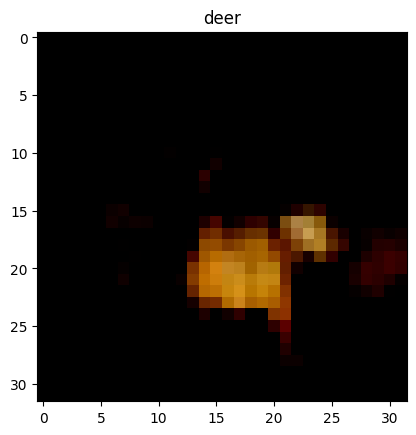

In [34]:
# Displaying a random image
import matplotlib.pyplot as plt

# Extract a single image and its corresponding label from the training dataset
image, label = train_data[3]

# Print the shape of the image tensor
print(f"Image shape: {image.shape}")

# Display the image using matplotlib
plt.imshow(np.transpose(image, (1, 2, 0)))  # Transpose the image tensor to match matplotlib's format (height, width, channels)
plt.title(class_names[label])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

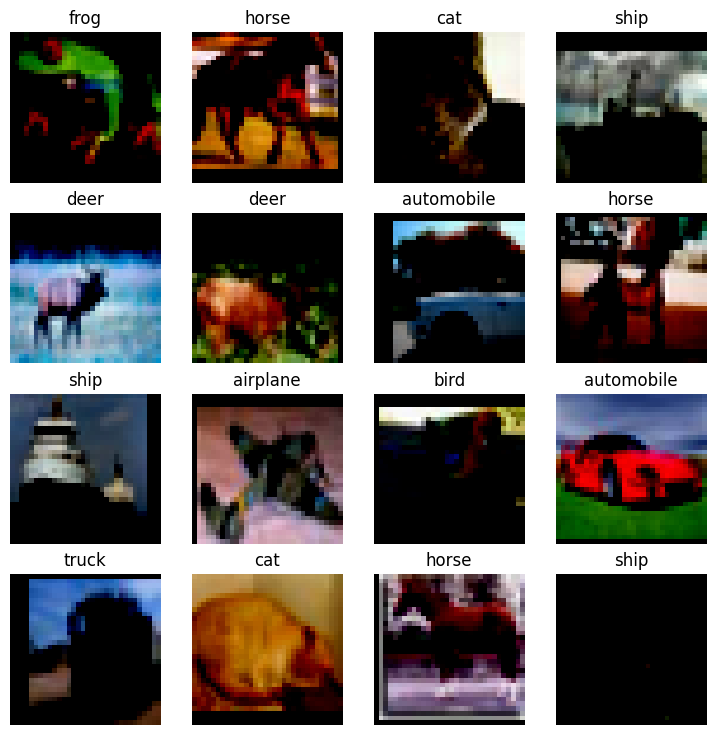

In [35]:
# Plotting more images
torch.manual_seed(random_seed)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(class_names[label])
    plt.axis(False);

In [36]:
from torch.utils.data import DataLoader

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fe62c6000d0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe6ee966150>)
Length of train dataloader: 782 batches of 64
Length of test dataloader: 157 batches of 64


In [37]:
# Inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

# Baseline Model Architecture

## Task 2: Implementation of Neural Network Architecture (40%)

### Basic Model : Intermediate Block Class, OutputBlock Class and BasicModel Class

The Baseline Model Architecture consists of 3 classes IntermediateBlock, OutputBlock and Basic_Model classes which are subclassed from nn.Module class

1. `IntermediateBlock`:
   - This class is used to define a series of intermediate blocks responsible for feature extraction from the input data.
   - Each instance of this block consists of a specified number of convolutional layers followed by batch normalization and an activation function (ReLu).
   - Each layer applies a convolution operation to its input, with parameters for the number of input channels (in_channels), number of output channels (out_channels), kernel size, padding, and stride.
   - Batch Normalization Follows each convolutional operation to stabilize learning by normalizing the output of the previous layer. This can lead to faster convergence and improved overall network performance.
   - The activation function introduces non-linearity into the model, enabling it to learn complex patterns.
   - A linear layer that reduces the dimensionality of the channel-averaged input to match the number of convolutional layers. This layer is crucial for computing weights that are used in a weighted sum operation, effectively combining the outputs of the convolutional layers
   - After the convolutional layers, there is a fully connected layer (`fc`) that computes weights (`a`) using softmax activation. These weights are are then combined to get the feature maps generated by the convolutional layers.
   - The final output (`x_prime`) is the weighted sum of the feature maps.

2. `OutputBlock`:
   - This class defines the output block or classifier block of the model, responsible for producing the final classification logits.
   - The class computes the mean of feature maps along the 3 channels of the image before passing them through the fully connected layers.
   - It consists of multiple fully connected layers, each followed by activation (ReLU by default), except for the last layer.
   - Activation Function is applied between fully connected layers to introduce non-linearity, except for the output of the final layer which is intended to be logits.
   - The number of fully connected layers is determined by the `num_fc_layers` parameter.
   - The final fully connected layer maps the output to the number of classes in the classification task.

3. `Basic_Model`:
  **This class covers the overall network architecture, orchestrating the flow of data through a series of IntermediateBlock instances followed by an OutputBlock. It is the main class that integrates the feature extraction and classification components of the model.**

   - It initializes the first convolutional block (`conv_block_1`) with input channels to hidden units.
   - Additional intermediate blocks (`intermediate_blocks`) are created based on the `num_blocks` parameter, **each having the same architecture** as `conv_block_1`.
   - The output block (`output_block`) produces the final classification logits.
   - During the forward pass, input data is passed through the intermediate blocks sequentially within which in each convolution layers it passes parallely, followed by the output block to produce the final output.

In [38]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3, activation=nn.ReLU()):
        super(IntermediateBlock, self).__init__()
        
        # Initialize a ModuleList to store convolutional layers
        self.conv_layers = nn.ModuleList([])
        
        # Create num_layers sequential convolutional layers with batch normalization and activation
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=1),
                nn.BatchNorm2d(out_channels),
                activation
            ))
        
        # Fully connected layer to compute weights for combining feature maps
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Compute mean separately for each color channel
        m = x.mean([2, 3])
        
        # Calculate weights 'a' using a fully connected layer and apply softmax activation
        a = torch.softmax(self.fc(m), dim=1)
        
        # Weighted sum of feature maps from convolutional layers
        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        
        return x_prime


class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=2, activation=nn.ReLU()):
        super(OutputBlock, self).__init__()
        
        # Initialize a ModuleList to store fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        
        # Add a final fully connected layer to map to num_classes
        self.fc_layers.append(nn.Linear(in_channels, num_classes))
        
        # Activation function for fully connected layers
        self.activation = activation

    def forward(self, x):
        # Compute mean separately for each color channel
        m = x.mean([2, 3])
        
        # Pass through fully connected layers with ReLU activation
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        
        # Final fully connected layer to get the output logits
        o = self.fc_layers[-1](m)
        
        return o


class Basic_Model(nn.Module):
    def __init__(self, input_channels, hidden_units, output_shape, num_blocks, num_conv_layers, num_fc_layers):
        super(Basic_Model, self).__init__()
        
        # Number of intermediate blocks in the model
        self.num_blocks = num_blocks
        
        # First intermediate block with input_channels to hidden_units
        self.conv_block_1 = IntermediateBlock(input_channels, hidden_units, num_conv_layers)
        
        # Additional intermediate blocks
        self.intermediate_blocks = nn.ModuleList([
            IntermediateBlock(hidden_units, hidden_units, num_conv_layers) for _ in range(num_blocks - 1)
        ])
        
        # Output block
        self.output_block = OutputBlock(hidden_units, output_shape, num_fc_layers=num_fc_layers)

    def forward(self, x):
        # Pass through the first convolutional block
        x = self.conv_block_1(x)
        
        # Pass through additional intermediate blocks
        for block in self.intermediate_blocks:
            x = block(x)
        
        # Pass through the output block
        x = self.output_block(x)
        
        return x


In [39]:
# Initialize the Advanced_Model with the specified parameters
input_channels = 3  # CIFAR-10 images are RGB, thus have 3 channels
hidden_units = 10  # Example value, adjust based on your requirements
output_shape = 10  # CIFAR-10 has 10 classes
num_blocks = 4  # Number of intermediate blocks in the network
num_conv_layers = 4  # Number of convolutional layers per intermediate block
num_fc_layers = 2  # Number of fully connected layers per required in the output classifier block

# Instantiate the model
model = Basic_Model(
    input_channels=input_channels,
    hidden_units=hidden_units,
    output_shape=output_shape,
    num_blocks=num_blocks,
    num_conv_layers=num_conv_layers,
    num_fc_layers=num_fc_layers
).to(device)  # Move the model to the appropriate device (CPU or GPU)

print(model)

Basic_Model(
  (conv_block_1): IntermediateBlock(
    (conv_layers): ModuleList(
      (0-3): 4 x Sequential(
        (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (fc): Linear(in_features=3, out_features=4, bias=True)
  )
  (intermediate_blocks): ModuleList(
    (0-2): 3 x IntermediateBlock(
      (conv_layers): ModuleList(
        (0-3): 4 x Sequential(
          (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (fc): Linear(in_features=10, out_features=4, bias=True)
    )
  )
  (output_block): OutputBlock(
    (fc_layers): ModuleList(
      (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
    )
    (activation): ReLU()
  )
)


## Task 3: Choosing the Loss Function and Optimiser (5%)

#### Cross Entropy Loss

Cross-entropy loss function has actually been designed for multi-class classification problems. We make use of cross-entropy loss in our model training since it considers the probabilities through which our model predicts for each class. It penalizes the model more heavily for assigning low probabilities to the correct class, and less heavily for assigning high probabilities to incorrect classes.


**Reference:**
* https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
* https://encord.com/blog/an-introduction-to-cross-entropy-loss-functions/




In [40]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

#### Adam W Optimizer

I used the AdamW optimizer because it deals better with weight decay and, hence, generalization of the model.This makes sure the weight decay becomes a true form of regularization, applied directly to the parameters independent of the adaptive learning rates.

It is also one of the regularization technique that helps to prevent overfitting. In our multi-classification, overfitting can occur when the model learns the training data too well and fails to generalize to unseen data. Therefore, Weight decay has helped to prevent overfitting by forcing the model to have smaller weight.

I have tried other optimizers like SDG and Adam however, AdamW has shown better performance.

Reference: 
- https://www.analyticsvidhya.com/blog/2023/12/adam-optimizer/
- https://towardsdatascience.com/why-adamw-matters-736223f31b5d

In [41]:
# Optimizer
adamw_optimizer = torch.optim.AdamW(
    params=model.parameters(), lr=ADAMW_LEARNING_RATE, weight_decay=ADAMW_WEIGHT_DECAY
)

## Task 4: Training and Testing the Model (30%)

#### Defining Training and Testing Functions

In [42]:
def accuracy_fn(y_true, y_pred):
    """
    Calculate the accuracy of model predictions.

    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted labels.

    Returns:
        float: Accuracy percentage.
    """
    # Calculate the number of correct predictions by comparing y_true and y_pred
    correct = torch.eq(y_true, y_pred).sum().item()

    # Calculate accuracy as the ratio of correct predictions to total predictions
    acc = (correct / len(y_pred)) * 100

    return acc

In [43]:
def training_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):
    model.to(device)  # Move model to the appropriate device just once
    model.train()  # Set the model to training mode
    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)  # Send data to GPU/CPU

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Use .item() to convert loss to a Python number
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Zero the gradients before running the backward pass
        adamw_optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        adamw_optimizer.step()

    # Calculate average loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def testing_step(data_loader,
              model,
              loss_fn,
              accuracy_fn,
              device):
    model.to(device)  # Ensure model is on the right device
    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.inference_mode():  # Context manager for inference mode
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()  # Detach and convert loss
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate average loss and accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

In [44]:
from tqdm import tqdm  # Import tqdm library for progress tracking

torch.manual_seed(random_seed) # Setting random seed for reproducibility

epoch_train_loss = []
epoch_train_accuracy = []
epoch_test_loss = []
epoch_test_accuracy = []

for epoch in tqdm(range(EPOCHS), desc="Epochs Completed"):  # Iterate over epochs with tqdm progress bar
    print(f"Epoch: {epoch + 1}\n---------")  # Print current epoch number

    # Perform one training step on the training data
    train_loss, train_accuracy = training_step(data_loader=train_dataloader,
                   model=model,
                   loss_fn=loss_fn,
                   optimizer=adamw_optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)

    # Evaluate the model's performance on the test dataset
    test_loss, test_accuracy = testing_step(data_loader=test_dataloader,
                 model=model,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)

    # Storing metrics to lists for later plotting
    epoch_train_loss.append(train_loss)
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_loss.append(test_loss)
    epoch_test_accuracy.append(test_accuracy)


Epochs Completed:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1
---------


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Train loss: 1.91889 | Train accuracy: 24.92%


Epochs Completed:   3%|▎         | 1/35 [00:38<22:00, 38.85s/it]

Test loss: 1.76002 | Test accuracy: 30.89%

Epoch: 2
---------
Train loss: 1.62011 | Train accuracy: 37.20%


Epochs Completed:   6%|▌         | 2/35 [01:11<19:22, 35.21s/it]

Test loss: 1.62263 | Test accuracy: 36.97%

Epoch: 3
---------
Train loss: 1.49005 | Train accuracy: 43.13%


Epochs Completed:   9%|▊         | 3/35 [01:49<19:22, 36.34s/it]

Test loss: 1.48802 | Test accuracy: 43.83%

Epoch: 4
---------
Train loss: 1.39327 | Train accuracy: 47.37%


Epochs Completed:  11%|█▏        | 4/35 [02:29<19:29, 37.72s/it]

Test loss: 1.41247 | Test accuracy: 45.90%

Epoch: 5
---------
Train loss: 1.33398 | Train accuracy: 49.95%


Epochs Completed:  14%|█▍        | 5/35 [03:08<19:14, 38.50s/it]

Test loss: 1.55387 | Test accuracy: 44.39%

Epoch: 6
---------
Train loss: 1.29527 | Train accuracy: 51.90%


Epochs Completed:  17%|█▋        | 6/35 [03:46<18:27, 38.20s/it]

Test loss: 1.39494 | Test accuracy: 49.02%

Epoch: 7
---------
Train loss: 1.26017 | Train accuracy: 53.33%


Epochs Completed:  20%|██        | 7/35 [04:23<17:42, 37.93s/it]

Test loss: 1.86845 | Test accuracy: 39.84%

Epoch: 8
---------
Train loss: 1.22946 | Train accuracy: 54.70%


Epochs Completed:  23%|██▎       | 8/35 [05:01<17:02, 37.87s/it]

Test loss: 1.32998 | Test accuracy: 51.64%

Epoch: 9
---------
Train loss: 1.21217 | Train accuracy: 55.63%


Epochs Completed:  26%|██▌       | 9/35 [05:38<16:17, 37.59s/it]

Test loss: 1.32532 | Test accuracy: 50.02%

Epoch: 10
---------
Train loss: 1.19094 | Train accuracy: 56.34%


Epochs Completed:  29%|██▊       | 10/35 [06:15<15:33, 37.33s/it]

Test loss: 1.23218 | Test accuracy: 53.91%

Epoch: 11
---------
Train loss: 1.16901 | Train accuracy: 57.19%


Epochs Completed:  31%|███▏      | 11/35 [06:52<14:54, 37.28s/it]

Test loss: 1.19184 | Test accuracy: 56.88%

Epoch: 12
---------
Train loss: 1.15294 | Train accuracy: 58.19%


Epochs Completed:  34%|███▍      | 12/35 [07:24<13:37, 35.55s/it]

Test loss: 1.42104 | Test accuracy: 48.94%

Epoch: 13
---------
Train loss: 1.13515 | Train accuracy: 58.91%


Epochs Completed:  37%|███▋      | 13/35 [07:54<12:30, 34.10s/it]

Test loss: 1.27001 | Test accuracy: 53.58%

Epoch: 14
---------
Train loss: 1.12336 | Train accuracy: 59.12%


Epochs Completed:  40%|████      | 14/35 [08:25<11:36, 33.17s/it]

Test loss: 1.17411 | Test accuracy: 57.54%

Epoch: 15
---------
Train loss: 1.10418 | Train accuracy: 59.90%


Epochs Completed:  43%|████▎     | 15/35 [08:55<10:43, 32.18s/it]

Test loss: 1.16493 | Test accuracy: 57.41%

Epoch: 16
---------
Train loss: 1.09374 | Train accuracy: 60.41%


Epochs Completed:  46%|████▌     | 16/35 [09:25<09:58, 31.50s/it]

Test loss: 1.34114 | Test accuracy: 53.66%

Epoch: 17
---------
Train loss: 1.08200 | Train accuracy: 60.63%


Epochs Completed:  49%|████▊     | 17/35 [09:52<09:02, 30.12s/it]

Test loss: 1.33638 | Test accuracy: 51.91%

Epoch: 18
---------
Train loss: 1.07330 | Train accuracy: 61.09%


Epochs Completed:  51%|█████▏    | 18/35 [10:23<08:33, 30.20s/it]

Test loss: 1.43543 | Test accuracy: 50.66%

Epoch: 19
---------
Train loss: 1.06212 | Train accuracy: 61.70%


Epochs Completed:  54%|█████▍    | 19/35 [10:52<07:59, 29.96s/it]

Test loss: 1.20393 | Test accuracy: 56.54%

Epoch: 20
---------
Train loss: 1.05360 | Train accuracy: 61.83%


Epochs Completed:  57%|█████▋    | 20/35 [11:21<07:26, 29.79s/it]

Test loss: 1.18712 | Test accuracy: 57.63%

Epoch: 21
---------
Train loss: 1.04449 | Train accuracy: 62.09%


Epochs Completed:  60%|██████    | 21/35 [11:51<06:58, 29.89s/it]

Test loss: 1.27197 | Test accuracy: 55.30%

Epoch: 22
---------
Train loss: 1.03317 | Train accuracy: 62.53%


Epochs Completed:  63%|██████▎   | 22/35 [12:22<06:30, 30.05s/it]

Test loss: 1.16436 | Test accuracy: 58.09%

Epoch: 23
---------
Train loss: 1.01876 | Train accuracy: 63.26%


Epochs Completed:  66%|██████▌   | 23/35 [12:52<05:59, 29.99s/it]

Test loss: 1.21994 | Test accuracy: 57.58%

Epoch: 24
---------
Train loss: 1.01391 | Train accuracy: 63.32%


Epochs Completed:  69%|██████▊   | 24/35 [13:22<05:29, 29.96s/it]

Test loss: 1.29475 | Test accuracy: 54.98%

Epoch: 25
---------
Train loss: 1.00657 | Train accuracy: 63.47%


Epochs Completed:  71%|███████▏  | 25/35 [13:52<04:59, 29.95s/it]

Test loss: 1.06461 | Test accuracy: 61.82%

Epoch: 26
---------
Train loss: 0.99755 | Train accuracy: 64.03%


Epochs Completed:  74%|███████▍  | 26/35 [14:22<04:29, 29.96s/it]

Test loss: 1.32894 | Test accuracy: 56.59%

Epoch: 27
---------
Train loss: 0.99417 | Train accuracy: 64.14%


Epochs Completed:  77%|███████▋  | 27/35 [14:51<03:58, 29.82s/it]

Test loss: 1.44589 | Test accuracy: 49.54%

Epoch: 28
---------
Train loss: 0.98646 | Train accuracy: 64.39%


Epochs Completed:  80%|████████  | 28/35 [15:20<03:27, 29.67s/it]

Test loss: 1.47762 | Test accuracy: 50.52%

Epoch: 29
---------
Train loss: 0.97962 | Train accuracy: 64.62%


Epochs Completed:  83%|████████▎ | 29/35 [15:49<02:56, 29.45s/it]

Test loss: 1.19192 | Test accuracy: 58.33%

Epoch: 30
---------
Train loss: 0.97664 | Train accuracy: 64.72%


Epochs Completed:  86%|████████▌ | 30/35 [16:18<02:26, 29.35s/it]

Test loss: 1.39963 | Test accuracy: 54.93%

Epoch: 31
---------
Train loss: 0.96846 | Train accuracy: 65.07%


Epochs Completed:  89%|████████▊ | 31/35 [16:48<01:57, 29.32s/it]

Test loss: 1.01474 | Test accuracy: 63.12%

Epoch: 32
---------
Train loss: 0.96461 | Train accuracy: 65.02%


Epochs Completed:  91%|█████████▏| 32/35 [17:17<01:27, 29.28s/it]

Test loss: 1.01718 | Test accuracy: 63.69%

Epoch: 33
---------
Train loss: 0.96011 | Train accuracy: 65.32%


Epochs Completed:  94%|█████████▍| 33/35 [17:46<00:58, 29.21s/it]

Test loss: 1.36479 | Test accuracy: 54.99%

Epoch: 34
---------
Train loss: 0.95429 | Train accuracy: 65.65%


Epochs Completed:  97%|█████████▋| 34/35 [18:15<00:29, 29.10s/it]

Test loss: 1.31075 | Test accuracy: 55.18%

Epoch: 35
---------
Train loss: 0.94936 | Train accuracy: 65.76%


Epochs Completed: 100%|██████████| 35/35 [18:44<00:00, 32.13s/it]

Test loss: 1.01544 | Test accuracy: 64.10%



#### Loss and Accuracy Curves for Training and Test Dataset

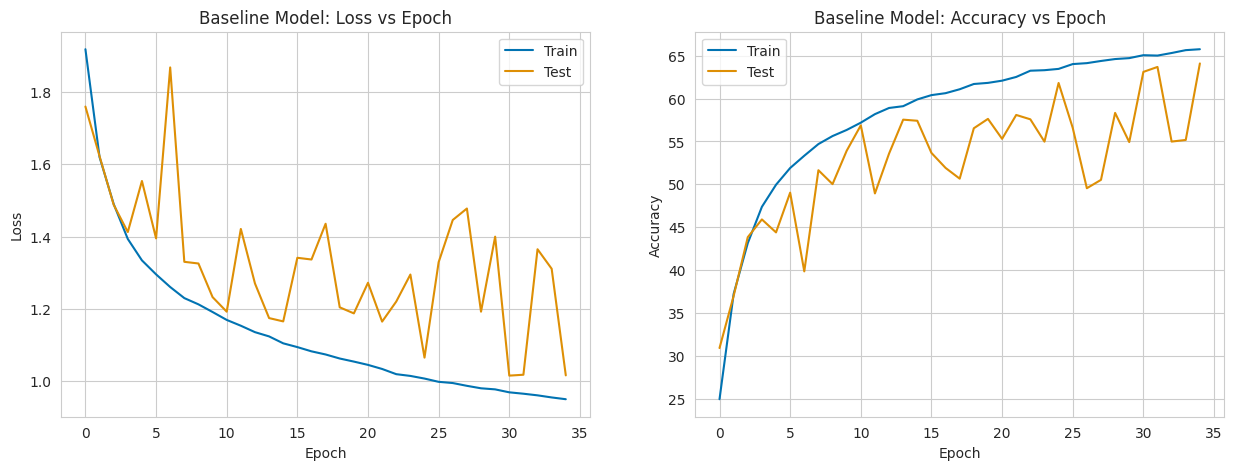

In [46]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.lineplot(ax=axes[0], x=range(EPOCHS), y=epoch_train_loss, label="Train")
sns.lineplot(ax=axes[0], x=range(EPOCHS), y=epoch_test_loss, label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Baseline Model: Loss vs Epoch")

sns.lineplot(ax=axes[1], x=range(EPOCHS), y=epoch_train_accuracy, label="Train")
sns.lineplot(ax=axes[1], x=range(EPOCHS), y=epoch_test_accuracy, label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("Baseline Model: Accuracy vs Epoch")
plt.show()


# Advanced Model Architecture

## Task 2: Implementation of Neural Network Architecture (40%)

### Advanced Model : Intermediate Block Class

**The Intermediate Block class defines a module for a block with multiple convolutional layers and adaptive pooling.**

* The block is initialized with parameters such as input and output channels, number of layers, kernel size, activation function, and dropout rate.

* A series of convolutional layers with batch normalization, activation function, and max pooling are created using nn.Sequential and stored in a ModuleList.

* The forward method defines the forward pass of the block:
  * Channel-wise averages of the input feature maps are computed using adaptive average pooling.
  * Coefficients 'a' are computed using a fully connected layer and softmax activation.
  * Each input feature map is weighted with its corresponding coefficient 'a' and combined to form the output feature map x_prime.

In [48]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size=3):
        super(IntermediateBlock, self).__init__()
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_layers = nn.ModuleList([])
        self.activation = nn.LeakyReLU(inplace=True)
        
        for _ in range(num_layers):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.MaxPool2d(
                        kernel_size=2, stride=2
                    ),
                # nn.Dropout(dropout_rate) 
            ))
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):      
        # Compute mean separately for each color channel
        m = self.adaptive_avg_pool(x).view(x.size(0), -1) 
        
        a = torch.softmax(self.fc(m), dim=1)  # Calculate 'a' using a fully connected layer
        # print(f"Shape of a vector {a.shape}")

        x_prime = sum(a[:, i].view(-1, 1, 1, 1) * conv(x) for i, conv in enumerate(self.conv_layers))
        # print(f"Shape of x_prime vector {x_prime.shape}")
        
        return x_prime

### Advanced Model: Output Block

**This block generates the final output of the neural network with the class-predictions for the input image.**

* It takes as input the output generated by the Intermediate Blocks of the neural network.
* Computes channel-wise averages of the input features using adaptive average pooling.
* Afterwards, the averages per channel-wise pass are done, and fully connected layers are applied to every layer with softmax activation in the end.
* The final fully connected layer maps the feature vectors to the number of classes, producing output logits.
* The output logits represent the model's probabilities for each class.

In [49]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_fc_layers=1, activation=nn.LeakyReLU()):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(num_fc_layers - 1)])
        self.fc_layers.append(nn.Linear(in_channels, num_classes))  # Final layer to num_classes
        self.activation = activation

    def forward(self, x):
        m = x.mean([2, 3])  # Compute mean separately for each color channel
        for fc in self.fc_layers[:-1]:
            m = self.activation(fc(m))
        o = self.fc_layers[-1](m)
        # print(o.shape)
        return o

### Advanced Model: Model Class

**This model combines multiple intermediate blocks followed by an output block to perform image classification.**

* It consists of multiple intermediate blocks, each processes features through convolutional layers.
* The first intermediate block processes input features from input_channels to hidden_units, while additional blocks process features within the hidden units.
* Each intermediate block utilizes the IntermediateBlock class.
* The output block generates the final predictions, mapping the hidden unit features to the specified output shape.
* In the forward method, input data passes through the first intermediate block, followed by additional intermediate blocks, and finally through the output block.
* The output of the output block represents the model's predictions for the input data.

In [50]:
class Advanced_Model(nn.Module):
    def __init__(self, input_channels, hidden_units, output_shape, num_blocks, num_conv_layers, num_fc_layers):
        super(Advanced_Model, self).__init__()
        self.num_blocks = num_blocks
        # First intermediate block with input_channels to hidden_units
        self.conv_block_1 = IntermediateBlock(input_channels, hidden_units, num_conv_layers)
        # Additional intermediate blocks
        self.intermediate_blocks = nn.ModuleList([
            IntermediateBlock(hidden_units, hidden_units, num_conv_layers) for _ in range(num_blocks - 1)
        ])
        # Output block
        self.output_block = OutputBlock(hidden_units, output_shape, num_fc_layers)

    def forward(self, x):
        x = self.conv_block_1(x)
        for block in self.intermediate_blocks:
            x = block(x)
        x = self.output_block(x)
        return x

In [14]:
# CIFAR-10 specific parameters
input_channels = 3  # CIFAR-10 images are RGB, thus have 3 channels
hidden_units = 512 # Example value, adjust based on your requirements
output_shape = 10  # CIFAR-10 has 10 classes
num_blocks = 5  # Number of intermediate blocks you want in your network
num_conv_layers = 5  # Number of convolutional layers per intermediate block
num_fc_layers = 4


# Instantiate the model
model = Advanced_Model(input_channels=input_channels,
                hidden_units=hidden_units,
                output_shape=output_shape,
                num_blocks=num_blocks,
                num_conv_layers=num_conv_layers,
                num_fc_layers=num_fc_layers).to(device)



## Task 3: Choosing the Loss Function and Optimiser (5%)

#### **Cross Entropy Loss:**

Cross-entropy loss function has actually been designed for multi-class classification problems. We make use of cross-entropy loss in our model training since it considers the probabilities through which our model predicts for each class. It penalizes the model more heavily for assigning low probabilities to the correct class, and less heavily for assigning high probabilities to incorrect classes.


**Reference:**
* https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
* https://encord.com/blog/an-introduction-to-cross-entropy-loss-functions/




In [51]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

#### Adam W Optimizer

I used the AdamW optimizer because it deals better with weight decay and, hence, generalization of the model.This makes sure the weight decay becomes a true form of regularization, applied directly to the parameters independent of the adaptive learning rates.

It is also one of the regularization technique that helps to prevent overfitting. In our multi-classification, overfitting can occur when the model learns the training data too well and fails to generalize to unseen data. Therefore, Weight decay has helped to prevent overfitting by forcing the model to have smaller weight.

I have tried other optimizers like SDG and Adam however, AdamW has shown better performance.

Reference: 
- https://www.analyticsvidhya.com/blog/2023/12/adam-optimizer/
- https://towardsdatascience.com/why-adamw-matters-736223f31b5d

In [15]:
ADAMW_LEARNING_RATE = 0.001
ADAMW_WEIGHT_DECAY = 1e-2

# Optimizer
adamw_optimizer = torch.optim.AdamW(
    params=model.parameters(), lr=ADAMW_LEARNING_RATE, weight_decay=ADAMW_WEIGHT_DECAY
)

## Task 4: Training and Testing the Model (30%)

#### Defining Training and Testing Functions

In [16]:
def accuracy_fn(y_true, y_pred):
    """
    Calculate the accuracy of model predictions.

    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted labels.

    Returns:
        float: Accuracy percentage.
    """
    # Calculate the number of correct predictions by comparing y_true and y_pred
    correct = torch.eq(y_true, y_pred).sum().item()

    # Calculate accuracy as the ratio of correct predictions to total predictions
    acc = (correct / len(y_pred)) * 100

    return acc

**Below code defines two functions, `training_step` and `testing_step`, essential for training and evaluating a neural network model.**

Each function takes different parameters necessary for their respective processes and performs a series of operations to process the input data through the model, calculate loss and accuracy, and adjust the model's weights during training. 

The `training_step` function is responsible for adjusting the model's parameters based on the training data to minimize the loss function, while the `testing_step` function evaluates the trained model's performance in terms of loss and accuracy on unseen data. 

`training_step` Function:

This performs a single epoch of training over the entire dataset provided by `data_loader`.

**Parameters:**
- `model`: The neural network model to be trained.
- `data_loader`: An iterable that provides batches of data (features `X` and labels `y`).
- `loss_fn`: The loss function used to calculate the difference between the predicted outputs and the actual labels.
- `optimizer`: The optimizer (AdamW optimizer) used for adjusting the model's weights based on the computed gradients to minimize the loss.
- `accuracy_fn`: A function that calculates the model's accuracy given the true labels and predictions.
- `device`: The device (CPU or GPU) where the computations are performed.

**Process:**
1. Moves the model to the appropriate device (CPU or GPU).
2. Sets the model to training mode to enable gradients and dropout layers.
3. Initializes variables for accumulating total loss and accuracy.
4. Iterates over batches of data from `data_loader`, moving each batch to the designated device.
5. For each batch, performs a forward pass through the model to generate predictions, computes the loss using `loss_fn`, and accumulates the loss and accuracy.
6. Resets (zeroes) the optimizer's gradients to prevent accumulation from previous iterations.
7. Performs a backward pass to compute gradients w.r.t the loss.
8. Updates the model's weights using the optimizer's step function.
9. Calculates and prints the average loss and accuracy over all batches.

`testing_step` Function:

This evaluates the model's performance on a dataset, typically a validation or test set, provided by `data_loader`.

**Parameters:**
Similar to `training_step`, but there's no optimizer since the model is not being updated.

**Process:**
1. Moves the model to the appropriate device.
2. Sets the model to evaluation mode to disable gradients and dropout layers for consistent predictions.
3. Initializes variables for accumulating total loss and accuracy.
4. Disables gradient calculations using `torch.inference_mode()` for efficiency during evaluation.
5. Iterates over batches of data, moving each batch to the device, and performs a forward pass to generate predictions.
6. Computes and accumulates the loss and accuracy for each batch.
7. Calculates and prints the average loss and accuracy over all batches.



In [17]:
def training_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):
    model.to(device)  # Move model to the appropriate device just once
    model.train()  # Set the model to training mode
    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)  # Send data to GPU/CPU

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Use .item() to convert loss to a Python number
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Zero the gradients before running the backward pass
        adamw_optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        adamw_optimizer.step()

    # Calculate average loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def testing_step(data_loader,
              model,
              loss_fn,
              accuracy_fn,
              device):
    model.to(device)  # Ensure model is on the right device
    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.inference_mode():  # Context manager for inference mode
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()  # Detach and convert loss
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate average loss and accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

In [18]:
from tqdm import tqdm  # Import tqdm library for progress tracking

torch.manual_seed(42) # Setting random seed for reproducibility

epoch_train_loss = []
epoch_train_accuracy = []
epoch_test_loss = []
epoch_test_accuracy = []

for epoch in tqdm(range(EPOCHS), desc="Epochs Completed"):  # Iterate over epochs with tqdm progress bar
    print(f"Epoch: {epoch + 1}\n---------")  # Print current epoch number

    # Perform one training step on the training data
    train_loss, train_accuracy = training_step(data_loader=train_dataloader,
                   model=model,
                   loss_fn=loss_fn,
                   optimizer=adamw_optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)

    # Evaluate the model's performance on the test dataset
    test_loss, test_accuracy = testing_step(data_loader=test_dataloader,
                 model=model,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)

    # Storing metrics to lists for later plotting
    epoch_train_loss.append(train_loss)
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_loss.append(test_loss)
    epoch_test_accuracy.append(test_accuracy)


Epochs Completed:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1
---------


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Train loss: 1.62429 | Train accuracy: 37.13%


Epochs Completed:   3%|▎         | 1/35 [01:42<57:49, 102.05s/it]

Test loss: 1.40977 | Test accuracy: 48.36%

Epoch: 2
---------
Train loss: 1.15335 | Train accuracy: 58.29%


Epochs Completed:   6%|▌         | 2/35 [03:28<57:39, 104.85s/it]

Test loss: 1.10913 | Test accuracy: 61.41%

Epoch: 3
---------
Train loss: 0.92918 | Train accuracy: 67.05%


Epochs Completed:   9%|▊         | 3/35 [04:53<51:05, 95.79s/it] 

Test loss: 0.93861 | Test accuracy: 68.17%

Epoch: 4
---------
Train loss: 0.80654 | Train accuracy: 71.67%


Epochs Completed:  11%|█▏        | 4/35 [06:28<49:14, 95.31s/it]

Test loss: 0.90792 | Test accuracy: 70.10%

Epoch: 5
---------
Train loss: 0.71145 | Train accuracy: 75.42%


Epochs Completed:  14%|█▍        | 5/35 [08:12<49:17, 98.60s/it]

Test loss: 0.69604 | Test accuracy: 76.09%

Epoch: 6
---------
Train loss: 0.63631 | Train accuracy: 78.10%


Epochs Completed:  17%|█▋        | 6/35 [09:54<48:05, 99.49s/it]

Test loss: 0.66258 | Test accuracy: 77.72%

Epoch: 7
---------
Train loss: 0.57649 | Train accuracy: 80.21%


Epochs Completed:  20%|██        | 7/35 [11:31<46:03, 98.71s/it]

Test loss: 0.68339 | Test accuracy: 77.28%

Epoch: 8
---------
Train loss: 0.52254 | Train accuracy: 81.87%


Epochs Completed:  23%|██▎       | 8/35 [13:12<44:44, 99.41s/it]

Test loss: 0.57584 | Test accuracy: 80.66%

Epoch: 9
---------
Train loss: 0.48680 | Train accuracy: 83.36%


Epochs Completed:  26%|██▌       | 9/35 [14:31<40:22, 93.17s/it]

Test loss: 0.58926 | Test accuracy: 80.54%

Epoch: 10
---------
Train loss: 0.44950 | Train accuracy: 84.72%


Epochs Completed:  29%|██▊       | 10/35 [15:42<36:00, 86.43s/it]

Test loss: 0.51459 | Test accuracy: 82.94%

Epoch: 11
---------
Train loss: 0.41560 | Train accuracy: 85.81%


Epochs Completed:  31%|███▏      | 11/35 [16:52<32:31, 81.32s/it]

Test loss: 0.46783 | Test accuracy: 84.47%

Epoch: 12
---------
Train loss: 0.38467 | Train accuracy: 86.80%


Epochs Completed:  34%|███▍      | 12/35 [18:02<29:52, 77.95s/it]

Test loss: 0.53182 | Test accuracy: 82.62%

Epoch: 13
---------
Train loss: 0.35835 | Train accuracy: 87.99%


Epochs Completed:  37%|███▋      | 13/35 [19:09<27:16, 74.38s/it]

Test loss: 0.47459 | Test accuracy: 84.09%

Epoch: 14
---------
Train loss: 0.33811 | Train accuracy: 88.46%


Epochs Completed:  40%|████      | 14/35 [20:13<24:59, 71.40s/it]

Test loss: 0.46937 | Test accuracy: 84.94%

Epoch: 15
---------
Train loss: 0.30866 | Train accuracy: 89.29%


Epochs Completed:  43%|████▎     | 15/35 [22:00<27:21, 82.07s/it]

Test loss: 0.43814 | Test accuracy: 85.65%

Epoch: 16
---------
Train loss: 0.29362 | Train accuracy: 89.93%


Epochs Completed:  46%|████▌     | 16/35 [23:49<28:32, 90.14s/it]

Test loss: 0.43989 | Test accuracy: 85.73%

Epoch: 17
---------
Train loss: 0.27370 | Train accuracy: 90.54%


Epochs Completed:  49%|████▊     | 17/35 [25:38<28:47, 95.96s/it]

Test loss: 0.40677 | Test accuracy: 86.97%

Epoch: 18
---------
Train loss: 0.25580 | Train accuracy: 91.33%


Epochs Completed:  51%|█████▏    | 18/35 [27:28<28:20, 100.01s/it]

Test loss: 0.42219 | Test accuracy: 87.44%

Epoch: 19
---------
Train loss: 0.24735 | Train accuracy: 91.50%


Epochs Completed:  54%|█████▍    | 19/35 [29:54<30:23, 113.98s/it]

Test loss: 0.42394 | Test accuracy: 86.53%

Epoch: 20
---------
Train loss: 0.22707 | Train accuracy: 92.20%


Epochs Completed:  57%|█████▋    | 20/35 [32:11<30:11, 120.77s/it]

Test loss: 0.47608 | Test accuracy: 86.21%

Epoch: 21
---------
Train loss: 0.22228 | Train accuracy: 92.36%


Epochs Completed:  60%|██████    | 21/35 [33:57<27:09, 116.42s/it]

Test loss: 0.39358 | Test accuracy: 88.17%

Epoch: 22
---------
Train loss: 0.20739 | Train accuracy: 92.94%


Epochs Completed:  63%|██████▎   | 22/35 [35:42<24:29, 113.04s/it]

Test loss: 0.41310 | Test accuracy: 87.57%

Epoch: 23
---------
Train loss: 0.19561 | Train accuracy: 93.26%


Epochs Completed:  66%|██████▌   | 23/35 [37:08<20:58, 104.86s/it]

Test loss: 0.40109 | Test accuracy: 87.80%

Epoch: 24
---------
Train loss: 0.18205 | Train accuracy: 93.95%


Epochs Completed:  69%|██████▊   | 24/35 [38:35<18:15, 99.55s/it] 

Test loss: 0.42754 | Test accuracy: 87.16%

Epoch: 25
---------
Train loss: 0.17715 | Train accuracy: 94.02%


Epochs Completed:  71%|███████▏  | 25/35 [40:03<16:00, 96.07s/it]

Test loss: 0.39103 | Test accuracy: 88.54%

Epoch: 26
---------
Train loss: 0.16471 | Train accuracy: 94.36%


Epochs Completed:  74%|███████▍  | 26/35 [41:53<15:00, 100.08s/it]

Test loss: 0.50034 | Test accuracy: 86.65%

Epoch: 27
---------
Train loss: 0.16041 | Train accuracy: 94.62%


Epochs Completed:  77%|███████▋  | 27/35 [43:41<13:41, 102.72s/it]

Test loss: 0.42202 | Test accuracy: 88.04%

Epoch: 28
---------
Train loss: 0.15265 | Train accuracy: 94.72%


Epochs Completed:  80%|████████  | 28/35 [45:32<12:15, 105.07s/it]

Test loss: 0.38451 | Test accuracy: 88.48%

Epoch: 29
---------
Train loss: 0.15149 | Train accuracy: 94.83%


Epochs Completed:  83%|████████▎ | 29/35 [47:21<10:38, 106.37s/it]

Test loss: 0.46299 | Test accuracy: 86.98%

Epoch: 30
---------
Train loss: 0.14247 | Train accuracy: 95.09%


Epochs Completed:  86%|████████▌ | 30/35 [49:01<08:41, 104.30s/it]

Test loss: 0.43822 | Test accuracy: 88.02%

Epoch: 31
---------
Train loss: 0.13409 | Train accuracy: 95.37%


Epochs Completed:  89%|████████▊ | 31/35 [50:28<06:36, 99.15s/it] 

Test loss: 0.44073 | Test accuracy: 88.37%

Epoch: 32
---------
Train loss: 0.12787 | Train accuracy: 95.57%


Epochs Completed:  91%|█████████▏| 32/35 [51:59<04:50, 96.79s/it]

Test loss: 0.42804 | Test accuracy: 88.03%

Epoch: 33
---------
Train loss: 0.12471 | Train accuracy: 95.66%


Epochs Completed:  94%|█████████▍| 33/35 [53:31<03:10, 95.30s/it]

Test loss: 0.48436 | Test accuracy: 88.35%

Epoch: 34
---------
Train loss: 0.12135 | Train accuracy: 95.85%


Epochs Completed:  97%|█████████▋| 34/35 [55:03<01:34, 94.32s/it]

Test loss: 0.48174 | Test accuracy: 87.27%

Epoch: 35
---------
Train loss: 0.11675 | Train accuracy: 95.98%


Epochs Completed: 100%|██████████| 35/35 [56:34<00:00, 96.99s/it]

Test loss: 0.41915 | Test accuracy: 88.51%



#### Loss and Accuracy Curves for Training and Test Dataset

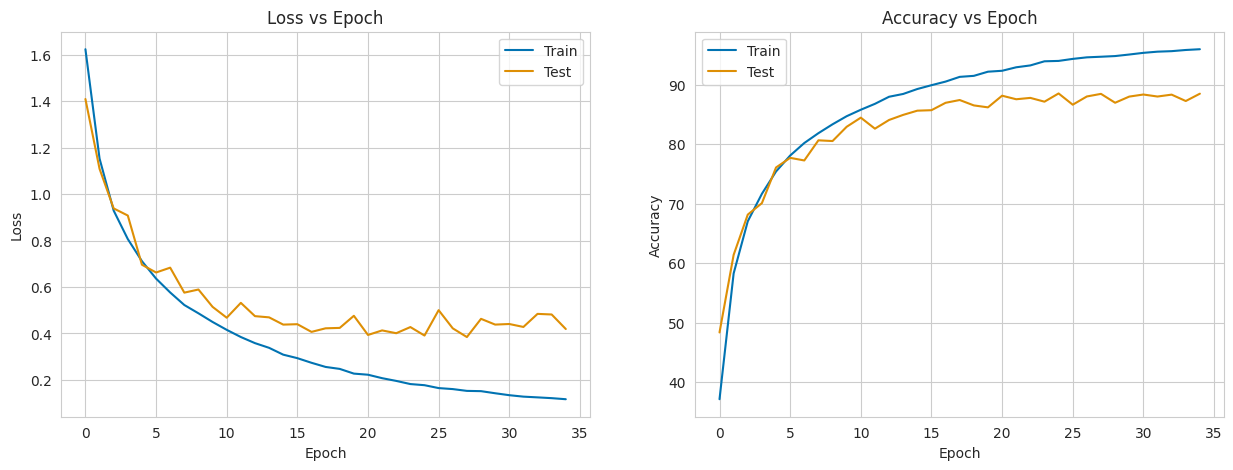

In [22]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sns.lineplot(ax=axes[0], x=range(EPOCHS), y=epoch_train_loss, label="Train")
sns.lineplot(ax=axes[0], x=range(EPOCHS), y=epoch_test_loss, label="Test")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Loss vs Epoch")

sns.lineplot(ax=axes[1], x=range(EPOCHS), y=epoch_train_accuracy, label="Train")
sns.lineplot(ax=axes[1], x=range(EPOCHS), y=epoch_test_accuracy, label="Test")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_title("Accuracy vs Epoch")
plt.savefig("loss_accuracy_plot.png")
plt.show()


## Model Metrics Analysis


- The model was trained for 35 epochs. 
                     
- After the final epoch, the basic model achieved a maximum training accuracy of 65.76% and a maximum test accuracy of 64.10%.
- After the final epoch, the advanced model achieved a maximum training accuracy of 95.98% and a maximum test accuracy of 88.51%.

The basic and advanced model loss and accuracy for the train and test dataset are given in the table below,


| Model-Dataset | Loss | Accuracy |
|---------|------|----------|
| Advanced-Train   | 0.11675|	95.98  |
| Advanced-Test    | 0.41915|	88.51  |
| Basic-Train   | 0.94936|	65.76  |
| Basic-Test    | 1.101544|	64.10  |


From the provided metrics for both the Basic and Advanced models trained over 35 epochs, here are the insights concerning their performance, effectiveness, and potential areas for improvement:

### Performance Analysis

1. **Training and Testing Accuracy:**
   - **Advanced Model:** Attained a high training accuracy of 95.98% but lower test accuracy, amounting to 88.51%. This 7% difference in training and test accuracy indicates that the advanced model learns the training dataset very well and generalizes reasonably to unseen data.
   - **Basic Model:** Training accuracy was 65.76%, and test accuracy was 64.10%. Although the training and testing results are close, the basic model exhibits an inability to capture the complexity of the dataset as effectively as the advanced model.

2. **Loss Metrics:**
   - **Advanced Model:** Recorded training and test losses of 0.11675 and 0.41915, respectively. The relatively lower training loss attests to effective learning, but the rise in test loss suggests minimal overfitting, though not significantly.
   - **Basic Model:** Exhibited higher training and test losses of 0.94936 and 1.101544, respectively. These higher losses at both training and testing phases indicate inadequate learning and generalization, pointing to potential underfitting or an inability to capture necessary patterns in the data.